#  XES analysis from TIFF files, 2023

> Energy = 9/17 keV

In [1]:
from model_xes import SpectrumAnalyzer
from remove_zero import delete_zero_rows_and_columns
from remove_zero import find_largest_center_zero_submatrix

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image #import glob
import json
import scipy.ndimage
import glob
from collections import OrderedDict
import matplotlib.ticker as mtick
import pandas as pd


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [71]:
spect = SpectrumAnalyzer()

In [32]:

make_png = False # This will output figures in figs folder.  It will overwrite.
force_reprocess = True # for reprocessing 

integrated_ref = True ## SC
save_iad = False

comp_to_show = [#'Fe',
                'FeO',
                #'Fe3O4',
                #'Fe2O3',
                #'Py',
                #'Fy', #Fayalite
                #'En', # MgSiO3
                #'OlSc', # SC olivine
                #'Gt', 
                #'FeOOH'
                ] # make sure you include composittion for run_of_interest
kb_not_show = ['OlSc', 'Gt']

In [6]:
pressure = {
    #### Fe
    #'171': None
    ###Pyrope, Py, 

    '195': 30, '198': 70, #'190': 65, 
    '204':127, '206': 131, '208': 180,  '212': 240,  '218': 290, #'210': 140,'215': 198,
    '245': 176, '251': 164, '270': 181,
    '387': 290, '395': 120, '398': 212, '476': 145, '481': 192, '484': 230,
    
    # Gt # 0 Gpa, meaning don't know pressure
    '225': 140, '229': 0, '231': 185, '234': 192, '236': 266, '264': 198, '266': 212, '268': 156, 
    '403': 45, '411': 143, '415': 208, '407': 63,  '486': 245, #'490' (no xray): 190, '471':205,
    #FeO
    '280': 0,#'254':None, '256': None, 
    '422': 154, '425': 140,  '432': 0,  '441': 124, '444': 46, #'427': 133,'430': None,
    '573': 220, '576': 0, '583': 120, '586': 150, '590': 61, '593': 367,
    # Fy
     '274': 0,#'261': None, 
    '552': 130, '559': 175, '562': 190, '565': 230, '568': 180, '597': 0, 
    # SC olivine
    '276': 320, '278': 200, 
    '461': 172, '464': 230, '469': 200,
    # FeooH
    '446': 0, '450': 0, 

}
composition = {
    #'171': 'Fe' 
     '195': 'Py', '198': 'Py', #'190': 'Py',
    '204': 'Py', '206': 'Py', '208': 'Py', '210': 'Py', '212': 'Py', '215': 'Py', '218': 'Py',
    '245': 'Py', '251': 'Py','270': 'Py',
    '225': 'Gt', '229': 'Gt', '231': 'Gt', '234': 'Gt', '236': 'Gt', '264': 'Gt', '266': 'Gt', '268': 'Gt',
    '254': 'FeO', '256': 'FeO', '280': 'FeO',
    '261': 'Fy', '274': 'Fy',
    '276': 'OlSc', '278': 'OlSc',
    '387': 'Py', '395': 'Py', '398' : 'Py', '476' :'Py', '481': 'Py','484':'Py',
    '403': 'Gt', '411': 'Gt', '415': 'Gt', '407': 'Gt', '471': 'Gt', '486': 'Gt', '490': 'Gt',
    '422': 'FeO', '425': 'FeO', '427':'FeO', '432': 'FeO', '430': 'FeO', '441': 'FeO', '444': 'FeO',
    '446': 'FeOOH', '450': 'FeOOH',
    '461': 'OlSc', '464': 'OlSc', '469': 'OlSc', 
    '552': 'Fy', '559': 'Fy', '562': 'Fy', '565': 'Fy', '568': 'Fy',
    '573': 'FeO', '576': 'FeO', '583': 'FeO', '586': 'FeO', '590':'FeO', '593': 'FeO',
    '597': 'Fy'
        
}
i_sec_std = ['387', '427', '450',  '552', '559', '562', '565', '568', '573', '576', '583', '586', '590', '593', '597']
#int_std_day4 = { 'Gt': [410], 
           #'Py': [385],
          # 'FeO': [431], 'FeOOH': [449],
           #'Fy': [596], 'OlSc':[463]}
standard_day2 = {'Py': '204', 'Gt' :'225', 'FeO': '280', 'Fy': '274', 'OlSc': '276'}
standard_day4 = {'Py': '387', 'Gt' :'411', 'FeO': '441', 'Fy': '597', 'OlSc': '464', 'FeOOH': '450'} # 195 for day1 pyrope; 387 for day4 Py; 
#int_std_day2 = {'Py': [203], 'FeO': [279], 'OlSc': [275], 
                #'Gt': [232], 'Fy': [273]}

#### parameters

> Below is the list of paramsters used in 2023 datasets.
>
> The smoothing parameter is 11, is because its  pixel/energy scale is much narrower than that of 2022/2024. 

In [84]:
spect.parm['roi']= 0
spect.parm['threshold'] = 1
spect.parm['n_moveavg']= 11
spect.parm['pix_shift']= 6
spect.parm['vmax'] = 80
i_l = spect.parm['intersect_l'] = 20
i_r = spect.parm['intersect_r'] = 50
i_g = spect.parm['intersect_guess'] = 36

def set_params(r_number):
    if int(r_number) < 377:
        #spect.parm['n_moveavg']= 11
        spect.parm['ka_r_l'] = 55
        spect.parm['ka_r_r'] = 63
        spect.parm['ka_c_l'] = 20
        spect.parm['ka_c_r'] = 160
        spect.parm['kb_r_l'] = 104
        spect.parm['kb_r_r'] = 114
        spect.parm['kb_c_l'] = 171
        spect.parm['kb_c_r'] = 301
        spect.parm['ka_r_l_bg'] = 64
        spect.parm['ka_r_r_bg'] = 74
        spect.parm['kb_r_l_bg'] = 93
        spect.parm['kb_r_r_bg'] = 103
        #spect.parm['kb_delete'] = [40, 41, 42, 43, 44, 45, 45, 47]
        spect.parm['tilt_cor'] = 0
        spect.parm['pix_ratio'] = 270/118 # pixel ratio
    else:
        #spect.parm['n_moveavg']= 11
        spect.parm['ka_r_l'] = 150
        spect.parm['ka_r_r'] = 159
        spect.parm['ka_c_l'] = 10
        spect.parm['ka_c_r'] = 180
        spect.parm['kb_r_l'] = 198
        spect.parm['kb_r_r'] = 204
        spect.parm['kb_c_l'] = 163 #150
        spect.parm['kb_c_r'] = 308 #320
        spect.parm['ka_r_l_bg'] = 160
        spect.parm['ka_r_r_bg'] = 169
        spect.parm['kb_r_l_bg'] = 191
        spect.parm['kb_r_r_bg'] = 197
        #spect.parm['kb_delete'] = [30, 31, 32, 33, 34]
        spect.parm['tilt_cor'] = -0.8
        spect.parm['pix_ratio'] = 2 # pixel ratio
    return spect.parm

In [8]:
folder = "../Data_day2/"
run_of_interest = '432'

In [33]:
ims = {}
ims_ref = {}
ref_num = {}
for r in pressure:
#r = run_of_interest    
    if composition[r] in comp_to_show:
        im = Image.open(folder + 'run'+r+'/Run_'+r+'_evt_1_Epix10ka_1.tiff')
        meta_data = spect.read_info_json(folder+'run'+r+'/info.json')
        imm = np.int32(im)
        submatrix, pos = find_largest_center_zero_submatrix(imm)
        imm = delete_zero_rows_and_columns(imm)
        immm = scipy.ndimage.rotate(imm, angle=set_params(r)['tilt_cor'])
        immm[immm < spect.parm['threshold']] = 0
        ims[r] = immm
        print('run #'+r, end='')
        print(submatrix, pos)
        if r in i_sec_std:
            r_ref = str(meta_data["SpotTestRunNum"])
            fl = glob.glob(folder+'run'+r_ref+'/Run_'+r_ref+'_evt_*_Epix10ka_1.tiff')
            im_ref = np.zeros_like(imm)
            for f in fl:
                im_r = Image.open(f)
                im_r = np.int32(im_r)
                im_r = delete_zero_rows_and_columns(im_r, submatrix, pos, fix = True)
                im_ref +=im_r
            print('--> 10% x 10 std'+', ref #'+r_ref)
        elif meta_data["FullPowerTestRunNum"] != 0:
            r_ref = str(meta_data["FullPowerTestRunNum"])
            im_ref = Image.open(folder+'run'+r_ref+'/Run_'+r_ref+'_evt_1_Epix10ka_1.tiff')
            im_ref = delete_zero_rows_and_columns(im_ref, submatrix, pos, fix = True)
            print('--> 100% x 1 std'+', ref #'+r_ref)

        ref_num[r] = r_ref
        imm_r = np.int32(im_ref)
        #imm_r = delete_zero_rows_and_columns(imm_r)
        immm_r = scipy.ndimage.rotate(imm_r, angle=set_params(r)['tilt_cor'])
        immm_r[immm_r < spect.parm['threshold']] = 0
        ims_ref[r] = np.int32(immm_r)
        if r == run_of_interest:
            run_of_interest_ref = r_ref
  

run #2805 (175, 191)
--> 100% x 1 std, ref #279
run #4225 (175, 191)
--> 100% x 1 std, ref #421
run #4255 (175, 191)
--> 100% x 1 std, ref #423
run #4325 (175, 191)
--> 100% x 1 std, ref #431
run #4415 (175, 191)
--> 100% x 1 std, ref #440
run #4445 (175, 191)
--> 100% x 1 std, ref #443
run #5735 (175, 191)
--> 10% x 10 std, ref #572
run #5765 (175, 191)
--> 10% x 10 std, ref #575
run #5835 (175, 191)
--> 10% x 10 std, ref #582
run #5865 (175, 191)
--> 10% x 10 std, ref #585
run #5905 (175, 191)
--> 10% x 10 std, ref #589
run #5935 (175, 191)
--> 10% x 10 std, ref #592


In [34]:
ims['432'].shape

(355, 387)

## Integrated Ref data

> See test part

> I rescale the x-range, this can help us to compare data in different years, See test parts


In [32]:
# for run_num> 377, 
#ref 407, and 401 are good
#garnet
'''
ref_comb = np.zeros((360, 392))
for i in ims_ref:
    if i in ['407', '411']:
        ref_comb += ims_ref[i]
    
ref_gt_day2= {}
for r in pressure:
    if int(r) > 377:
        if composition[r] =='Gt':
            ref_gt_day2[r] = ref_comb
            
#for reun_num<377
#Not very good ref, so i combine all 
ref_comb_day1 = np.zeros((355, 387))
for i in ims_ref:
    if int(i)<377 :
        ref_comb_day1 += ims_ref[i]
    
ref_gt_day1= {}
for r in pressure:
    if int(r) < 377:
        if composition[r] =='Gt':
            ref_gt_day1[r] = ref_comb_day1
'''

"\nref_comb = np.zeros((360, 392))\nfor i in ims_ref:\n    if i in ['407', '411']:\n        ref_comb += ims_ref[i]\n    \nref_gt_day2= {}\nfor r in pressure:\n    if int(r) > 377:\n        if composition[r] =='Gt':\n            ref_gt_day2[r] = ref_comb\n            \n#for reun_num<377\n#Not very good ref, so i combine all \nref_comb_day1 = np.zeros((355, 387))\nfor i in ims_ref:\n    if int(i)<377 :\n        ref_comb_day1 += ims_ref[i]\n    \nref_gt_day1= {}\nfor r in pressure:\n    if int(r) < 377:\n        if composition[r] =='Gt':\n            ref_gt_day1[r] = ref_comb_day1\n"

Text(0.5, 1.0, '1 bar spectrum')

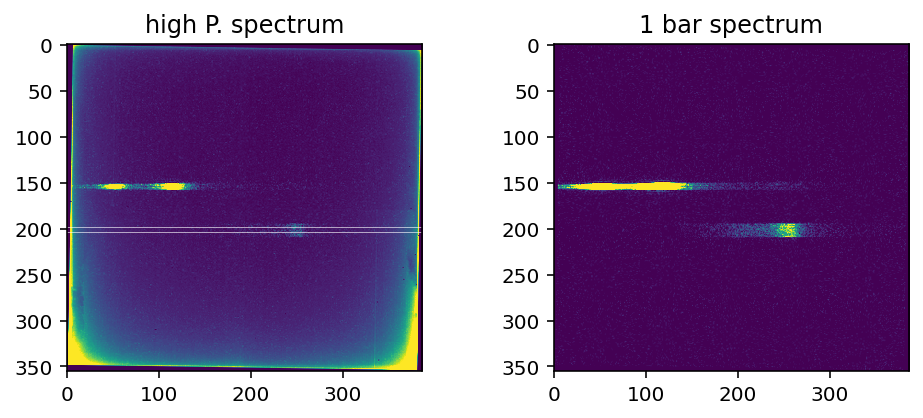

In [85]:
run_of_interest = '422'
f, axs = plt.subplots(1,2, figsize=(8,3))
axs[0].imshow(ims[run_of_interest], interpolation='none', vmax =spect.parm['vmax'])
axs[1].imshow(ims_ref[run_of_interest], interpolation='none', vmax =100)
pm = set_params('422')
#ttt = tt_im[pm['kb_r_l']: pm['kb_r_r'], pm['kb_c_l']:pm['kb_c_r']].sum(axis=0)
axs[0].axhline(pm['kb_r_l'], c='w', lw=0.3); axs[0].axhline(pm['kb_r_r'], c='w', lw=0.3)
axs[0].set_title('high P. spectrum')
axs[1].set_title('1 bar spectrum')
#plt.savefig('./lelia/432-2dimage.png', dpi = 200)

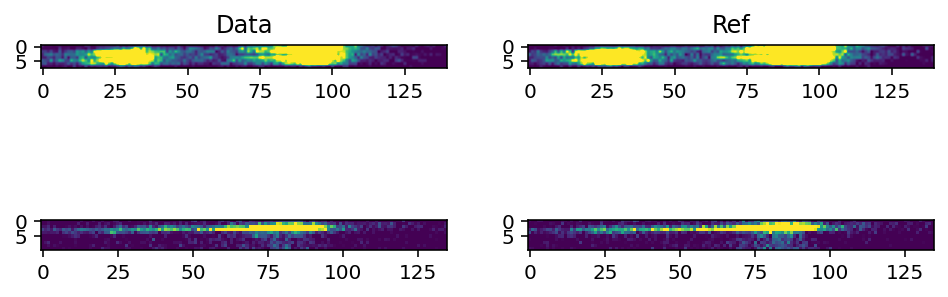

In [17]:
set_params(run_of_interest)
spect.img_ka_kb(run_of_interest, ims, ims_ref)

## calculate IAD


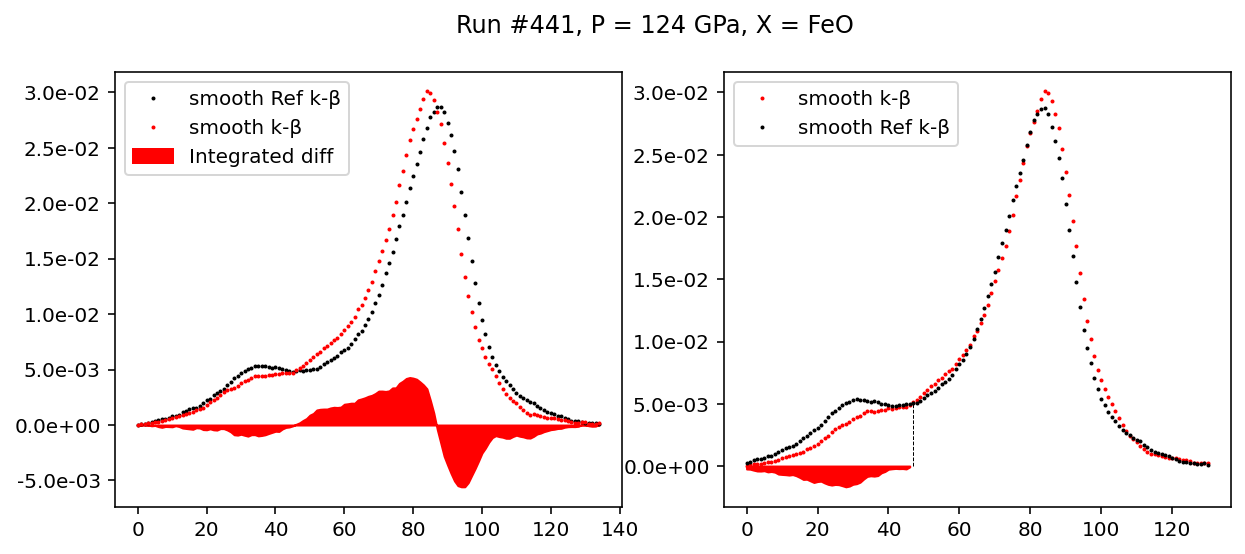

In [91]:
r = '441'
set_params(r)
f, ax = spect.kb_series_plot_new(r, ims, ims_ref, pressure, composition, std = None, i_l = i_l, i_r = i_r,i_g = i_g)
#print(std)

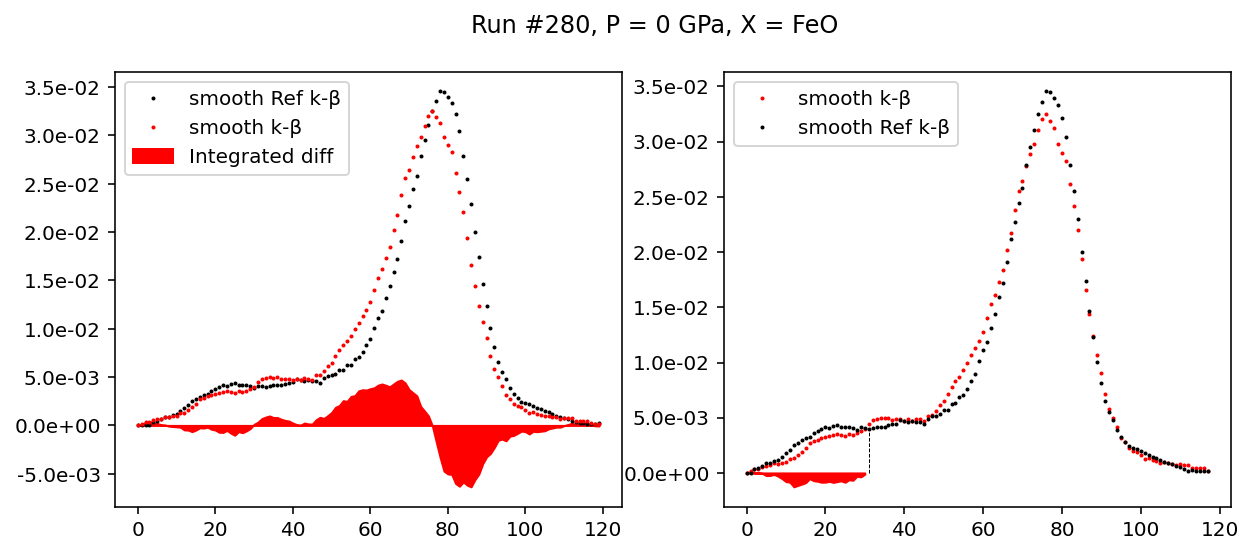

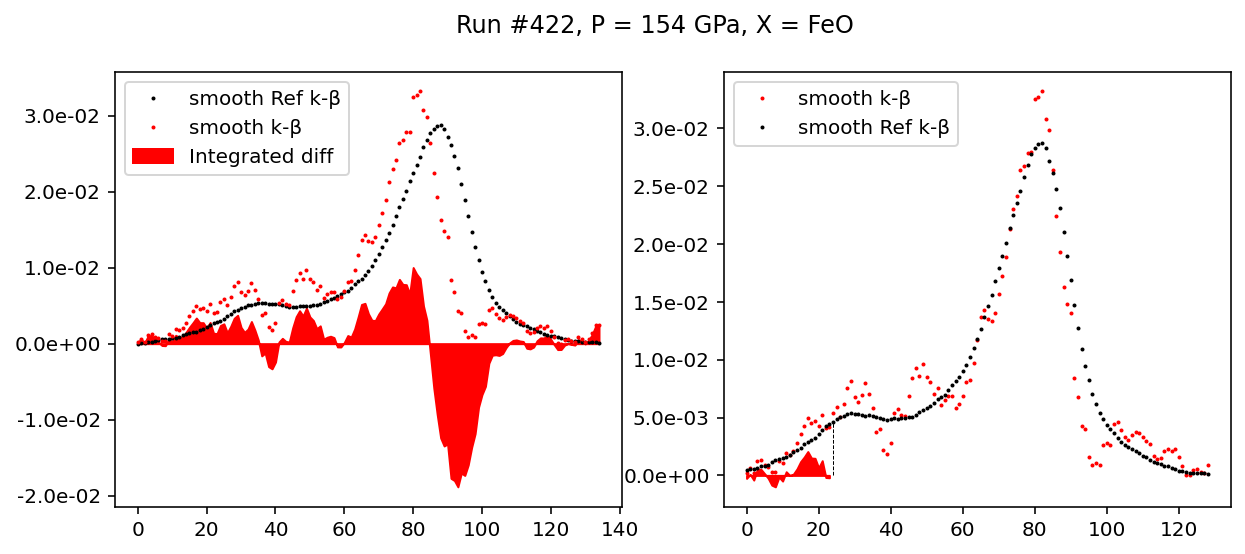

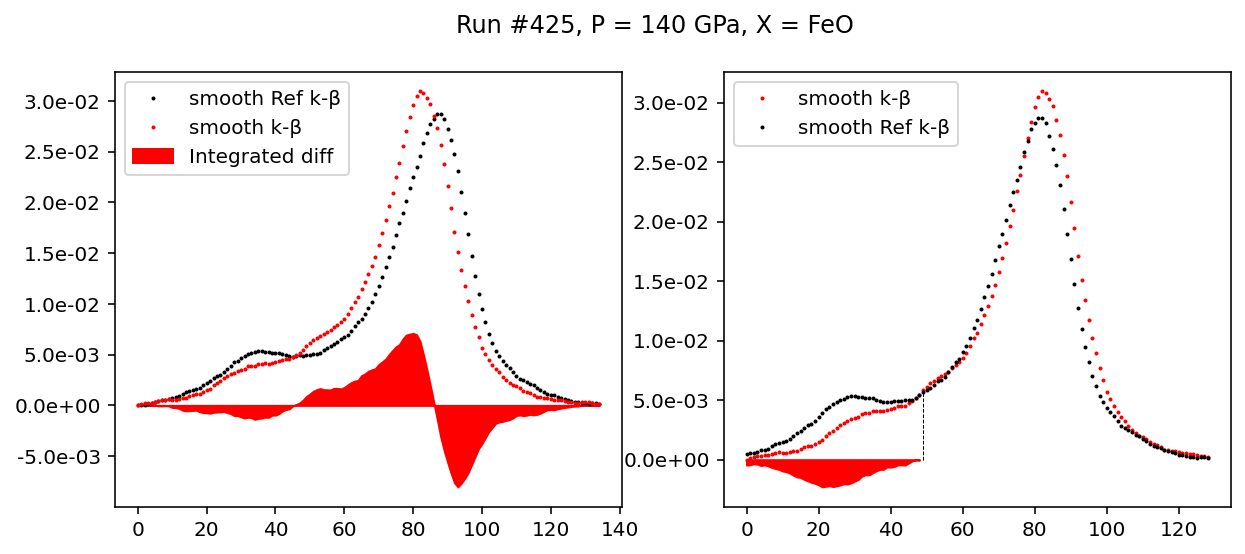

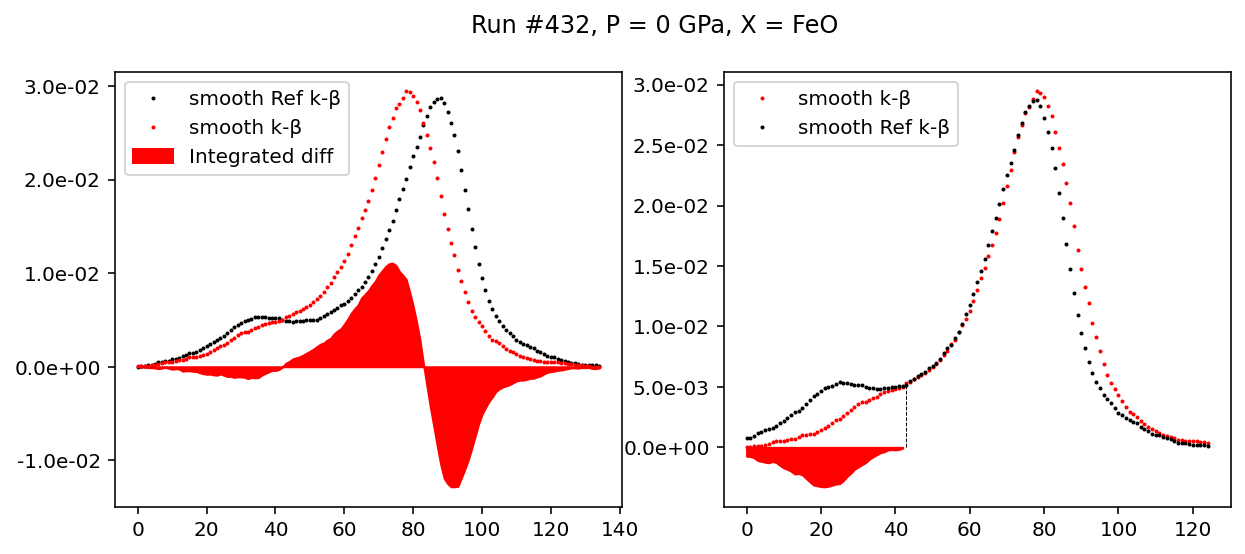

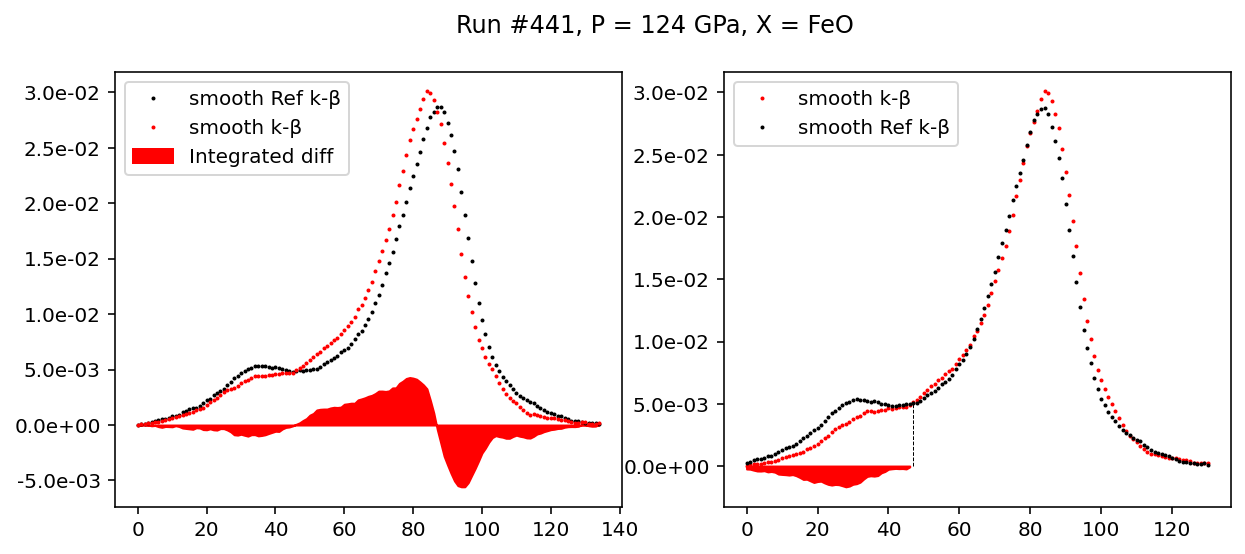

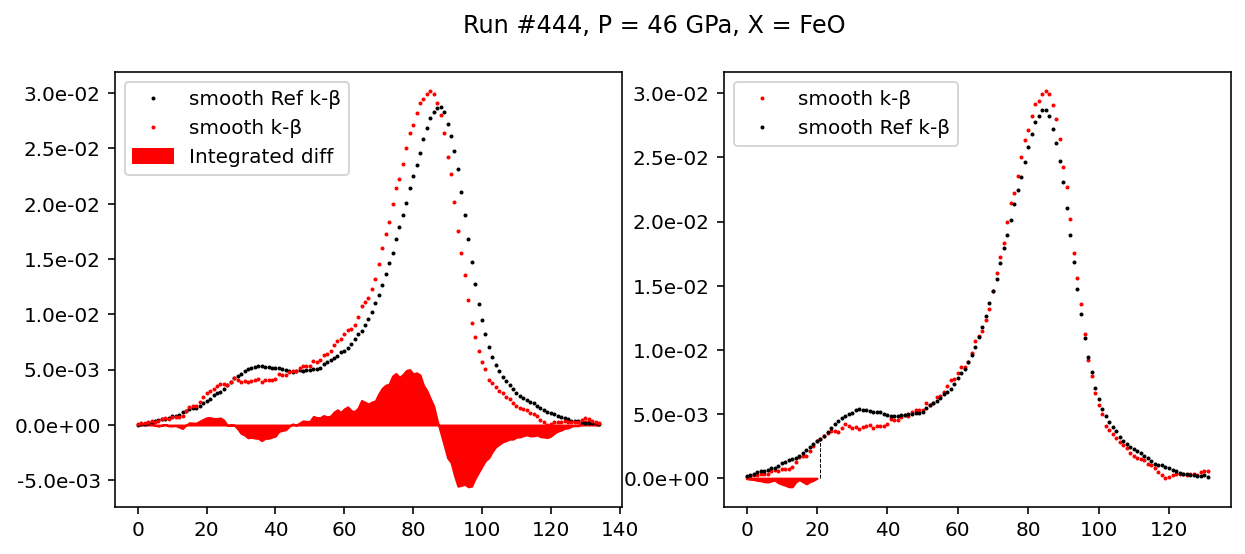

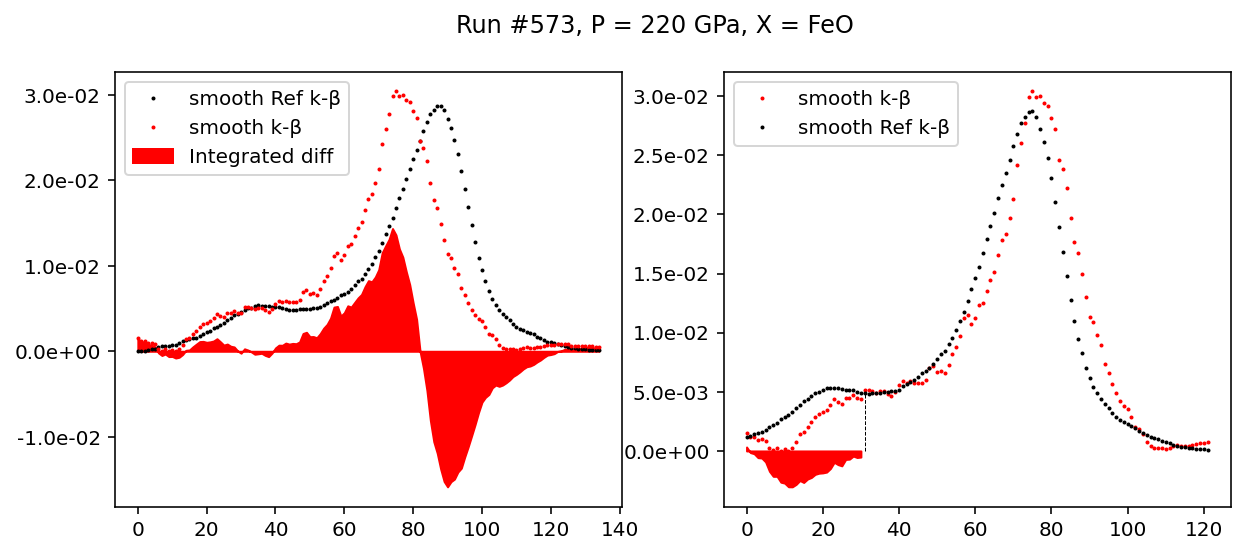

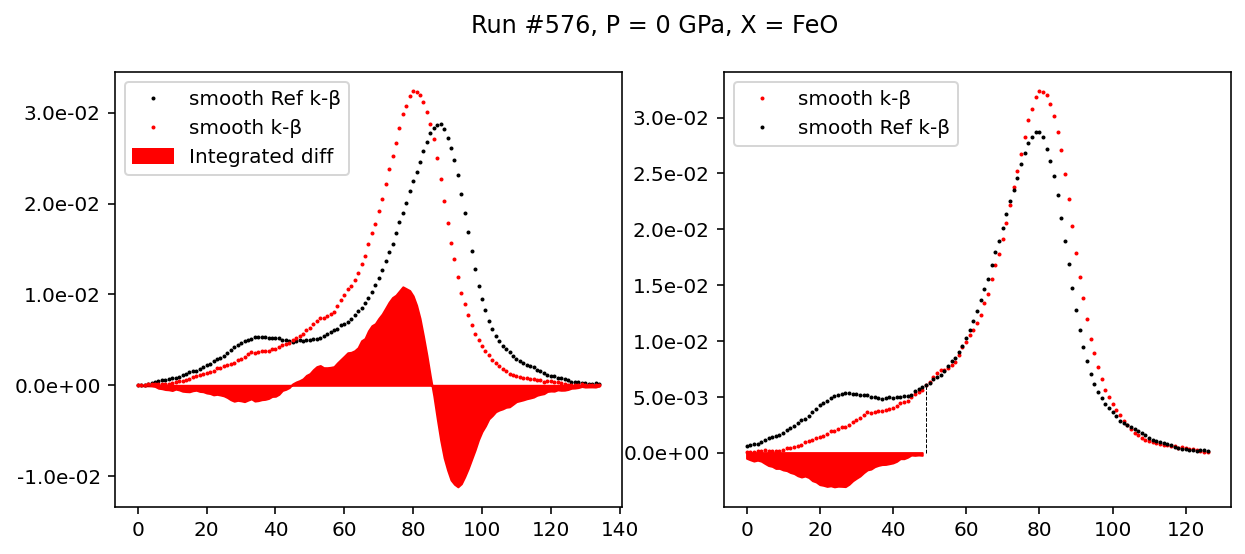

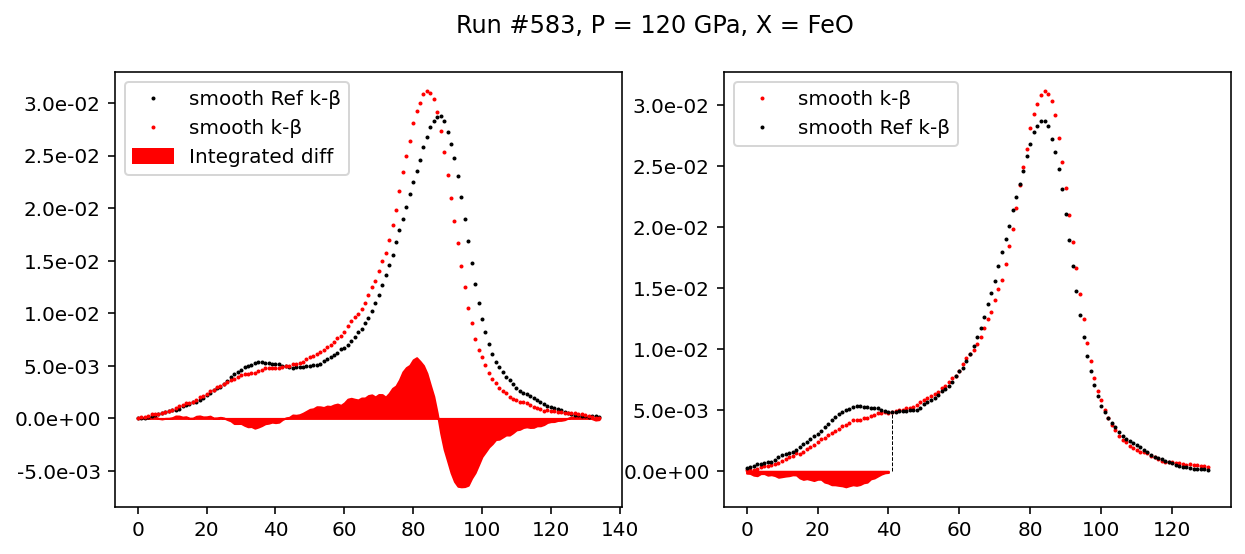

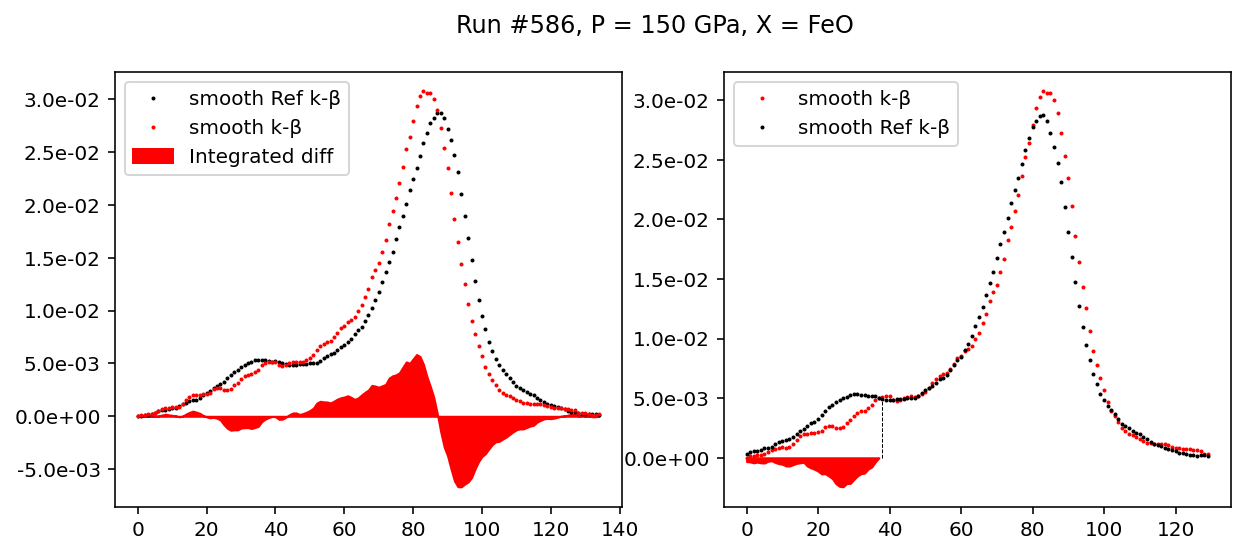

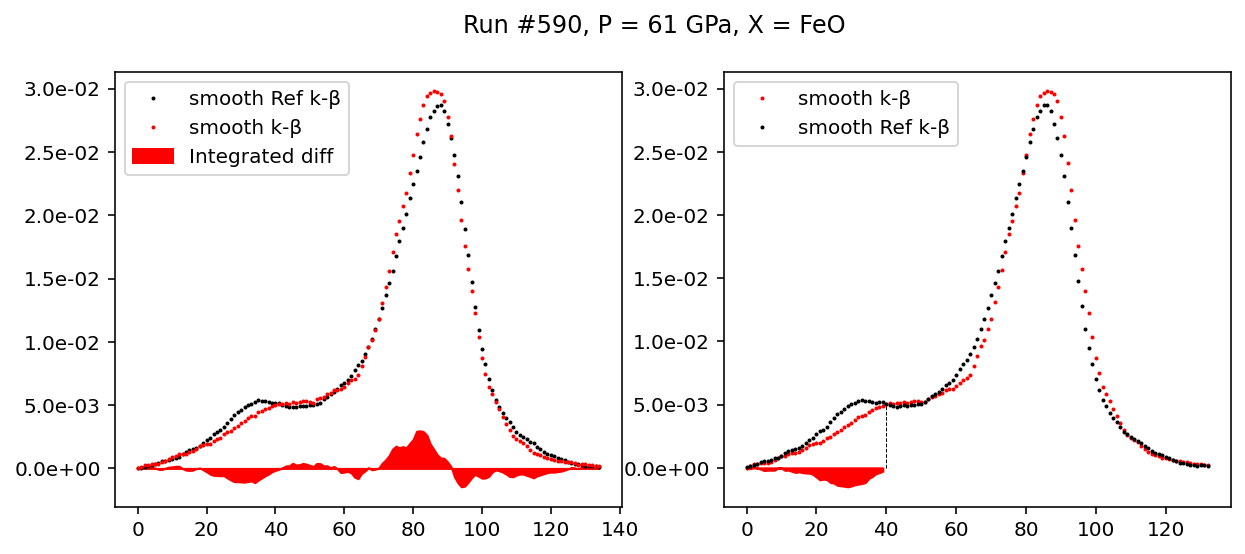

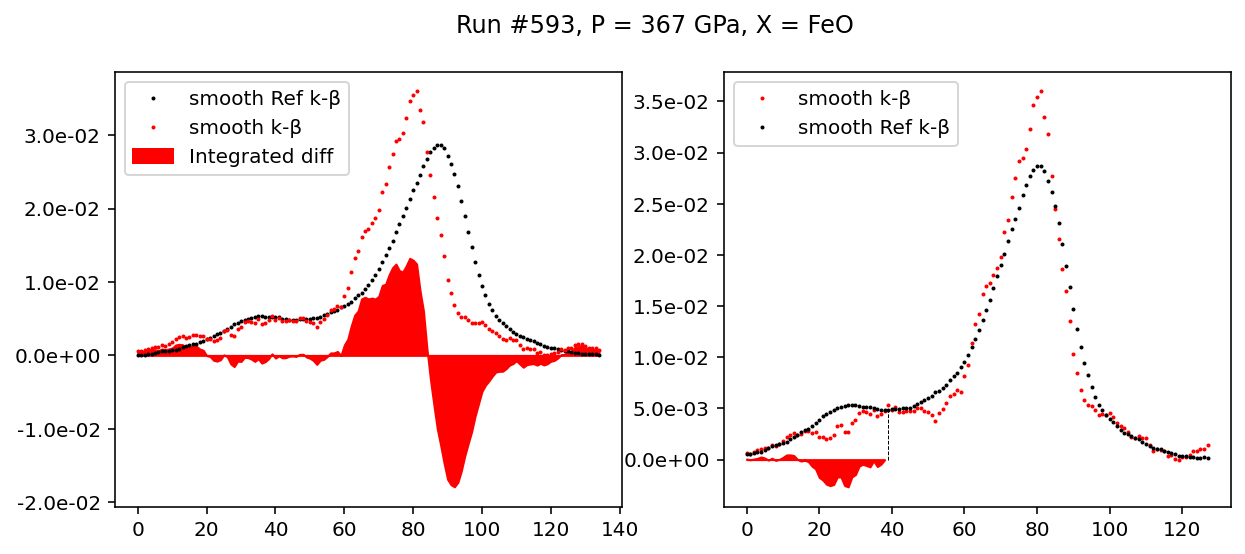

In [89]:
iad_kb = {}; iad_kbst = {}; prs_roi= {}
for r in pressure:
    if composition[r] in comp_to_show:
        if int(r) < 377:
            std = standard_day2
        else:
            std = standard_day4
        prs_roi[r] = pressure[r]
        set_params(r)
        #f, ax = kb_series_plot_new(r, ims, xes_ref, pressure, composition, std = None)[0:2]
        f, ax = spect.kb_series_plot_new(r, ims, ims_ref, pressure, composition, std = std, i_l = i_l, i_r = i_r, i_g = i_g)
        iad_kb[r] = spect.iad_kb(r, ims, ims_ref,pressure, composition)['iad smooth']
        iad_kbst[r] = spect.iad_kb_st(r, ims, ims_ref,pressure, composition, std = std, i_l = i_l, i_r = i_r, i_g = i_g)['iad smooth']
        plt.show()
        plt.close()
        if make_png:
            if r =='432':
                f.savefig('./lelia/images/'+ composition[r] +
                                 '_ka_' + str(pressure[r]) + 'GPa' +
                                 '_Run' + r + '_feo_ref.png', dpi = 300)

In [90]:
feo_iad_2023 = './lelia/feo_iad_2023.csv'
df = pd.DataFrame({'run num': iad_kb.keys(), 
                    'Pressure': prs_roi.values(),
                    'IAD_kb': iad_kb.values(),  
                    'IAD_kbst': iad_kbst.values()})
df.to_csv(feo_iad_2023, index=False)

In [46]:
def kb_series_plot_new(r, ims, ims_ref, pressure, composition, std = None, i_l = 50, i_r = 100, i_g = 91):
    '''
    This function will plot the IAD of K_beta and K_beta satellite
    '''
    f, axs = plt.subplots(1,2, figsize=(10,4))

    spec_raw = spect.get_roi_spectrum_kb(ims[r])
    spec_raw_rmbg = spect.bg_sub_spectrum_kb(ims[r])
    spec = spect.moving_average(spec_raw_rmbg)
    spec_n = spect.get_norm_spectrum(spect.lin_bg_sub(spec))
    if std: 
        std_r = std[composition[r]]
    else:
        std_r = r
    spec_ref_raw = spect.get_roi_spectrum_kb(ims_ref[std_r])
    spec_ref = spect.moving_average(spec_ref_raw)
    spec_r_n = spect.get_norm_spectrum(spect.lin_bg_sub(spec_ref))
    
    i_max = spec_n.argmax()
    i_ref_max = spec_r_n.argmax()
    i_dif =  i_ref_max - i_max
    
    if i_dif < 0:
        spec_align = spec_n[-i_dif:]
        spec_r_align = spec_r_n[:i_dif]
    elif i_dif > 0:
        spec_align = spec_n[:-i_dif]
        spec_r_align = spec_r_n[i_dif:]
    else:
        spec_align = spec_n
        spec_r_align = spec_r_n 

    transition_point = None
    for i in range(i_l, i_r):
        if spec_align[i] <= spec_r_align[i] and spec_align[i + 1] > spec_r_align[i + 1]:
            transition_point = i + 1
            break
    if transition_point is None:
        transition_point = i_g
    #x= spec_r_align[:150]
    #xpos = np.abs(x - np.max(spec_r_align)/2).argmin()
    

    axs[0].plot(spec_r_n, 'ko', markersize = 1, label = 'smooth Ref k-\u03B2')
    axs[0].plot(spec_n, 'ro', markersize = 1, label = 'smooth k-\u03B2')
    axs[0].fill_between(np.arange(len(spec)), 0, 
                        spec_n - spec_r_n,
                        color='r', label = 'Integrated diff')

    axs[1].plot(spec_align, 'ro', markersize = 1, label = 'smooth k-\u03B2')
    axs[1].plot(spec_r_align, 'ko', markersize = 1, label = 'smooth Ref k-\u03B2')
    axs[1].fill_between(np.arange(len(spec_align))[:transition_point], 0, spec_align[:transition_point] -spec_r_align[:transition_point],color='r')
    axs[1].vlines(transition_point, 0, spec_r_align[transition_point],color = 'k', linestyle='--', lw=0.5)

    f.suptitle('Run #' + r + ', P = ' + str(pressure[r]) + ' GPa' + ', X = ' + composition[r])
    axs[0].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
    axs[1].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
    
    axs[0].legend(); axs[1].legend()
    
    return f, axs, spec_n,spec_r_n,spec_align,spec_r_align, spec_align[:transition_point], spec_r_align[:transition_point], transition_point

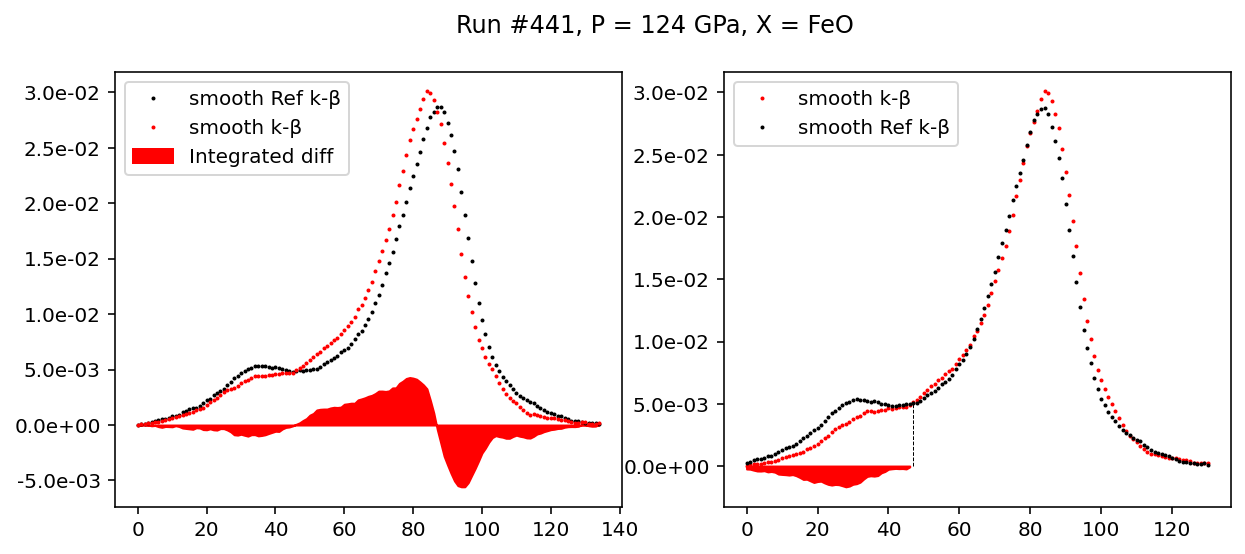

In [92]:
set_params('441')
f, ax, s, s_r, s_align, s_raligh, ss, ss_r, cp = kb_series_plot_new('441', ims, ims_ref, pressure, composition, std = None, i_l = i_l, i_r = i_r, i_g = i_g)

In [24]:
def save_data(s, s_r, ss, ss_r, run_num):
    max_length = len(s)
    # Pad each list to the maximum length
    s = s.tolist() + [None] * (max_length - len(s))
    s_r = s_r.tolist() + [None] * (max_length - len(s_r))
    ss = ss.tolist() + [None] * (max_length - len(ss))
    ss_r = ss_r.tolist() + [None] * (max_length - len(ss_r))

    feo_iad = './lelia/images/spectrum_data' + run_num + '.csv'
    df = pd.DataFrame({'spectrum': s, 
                    'spectrum_ref': s_r,
                    'satellite': ss,  
                    'satellite_ref': ss_r})
    df.to_csv(feo_iad, index=False)

In [25]:
save_data(s, s_r, ss, ss_r, '432')